# Overlay graphs
This notebook contains the code for generating graphs of central canal images with fluobeads overlayed with their respective velocities calculated with kymographs. Most of the code isn't optimized for practicality and performance, if I have some time I will clean it up.

In [32]:
from cerebroflow import kymo as ky
import PySimpleGUI as sg
import matplotlib.pyplot as plt
import matplotlib.image
import numpy as np
import matplotlib.lines as mlines
import os

# Import raw time lapse

path = "/Volumes/T7 Shield/01_CSF_FLOW/Cropped_images/WT/WT_C_14_denoised_cropped.tif"
path = os.path.normpath(path)
print("Image path: ",path)
# pixel size: 0.16250000000000003 (olympus 40x) or 0.189 (pub)
pixel_size = 0.16250000000000003
frame_time = 0.159
exp1 = ky.Kymo(path, pixel_size=pixel_size, frame_time=frame_time)
exp1.generate_kymo(threshold=0.5,dash=False)

Image path:  /Volumes/T7 Shield/01_CSF_FLOW/Cropped_images/WT/WT_C_14_denoised_cropped.tif
Input file: WT_C_14_denoised_cropped.tif

Processing images:


298it [00:00, 930.06it/s] 


Analyzing WT_C_14_denoised_cropped.tif:
threshold: 	0.5 
method: 	Quantile 
filter size: 	None
Normalizing kymograph:


100%|██████████| 432/432 [00:00<00:00, 3921.35it/s]


Linking trajectories:


100%|██████████| 429/429 [00:00<00:00, 2036.90it/s]


Detecting blobs and calculating velocitiesfor d-v positions:


100%|██████████| 429/429 [00:02<00:00, 204.11it/s]


Smoothing:  Smooth
Detected 429 traces.
Done! 



(array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.0

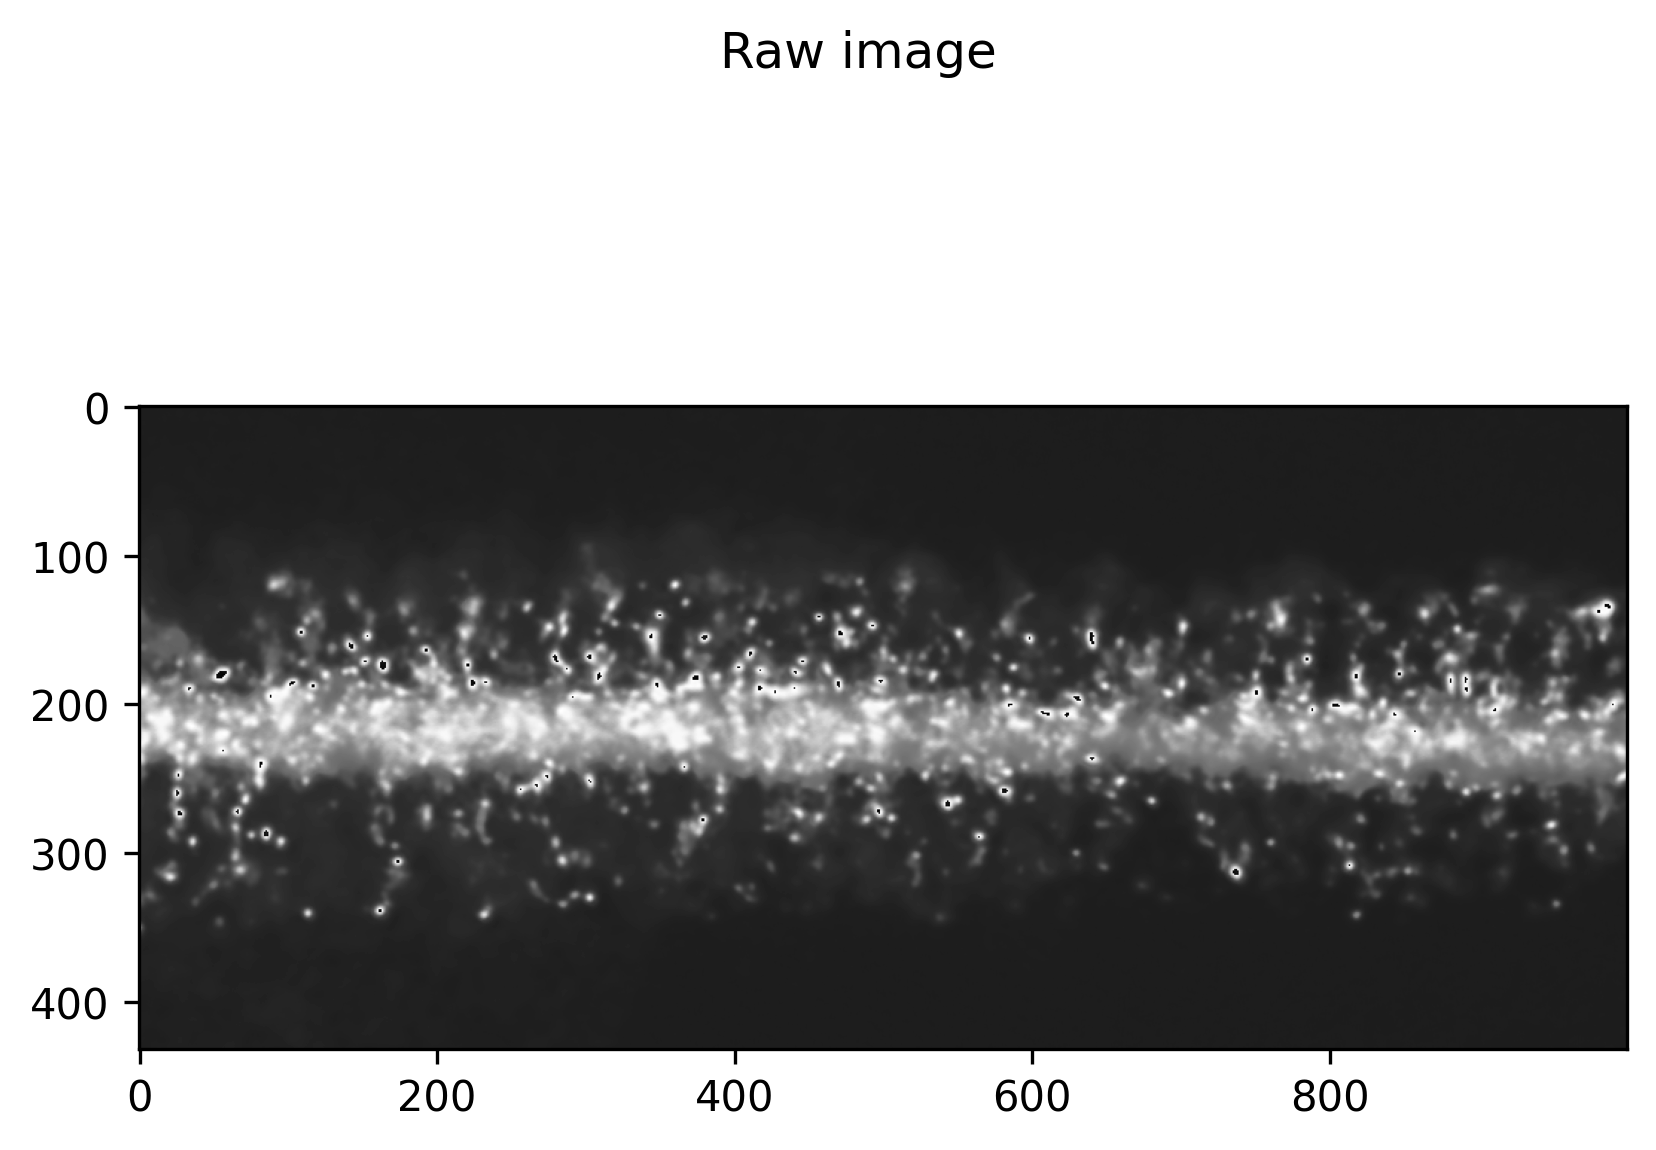

In [33]:
import matplotlib.pyplot as plt

# Assuming exp1 is an object containing image data
raw_image = exp1.images.copy()

# Create a figure and axes
fig, axs = plt.subplots()

# Display the first image from the copied images using axs.imshow()
img = axs.imshow(raw_image[0], cmap="gray")


plt.suptitle("Raw image")


# Show the plot
plt.show()


Detected regions at the first timepoint. (I should make a gif of it)

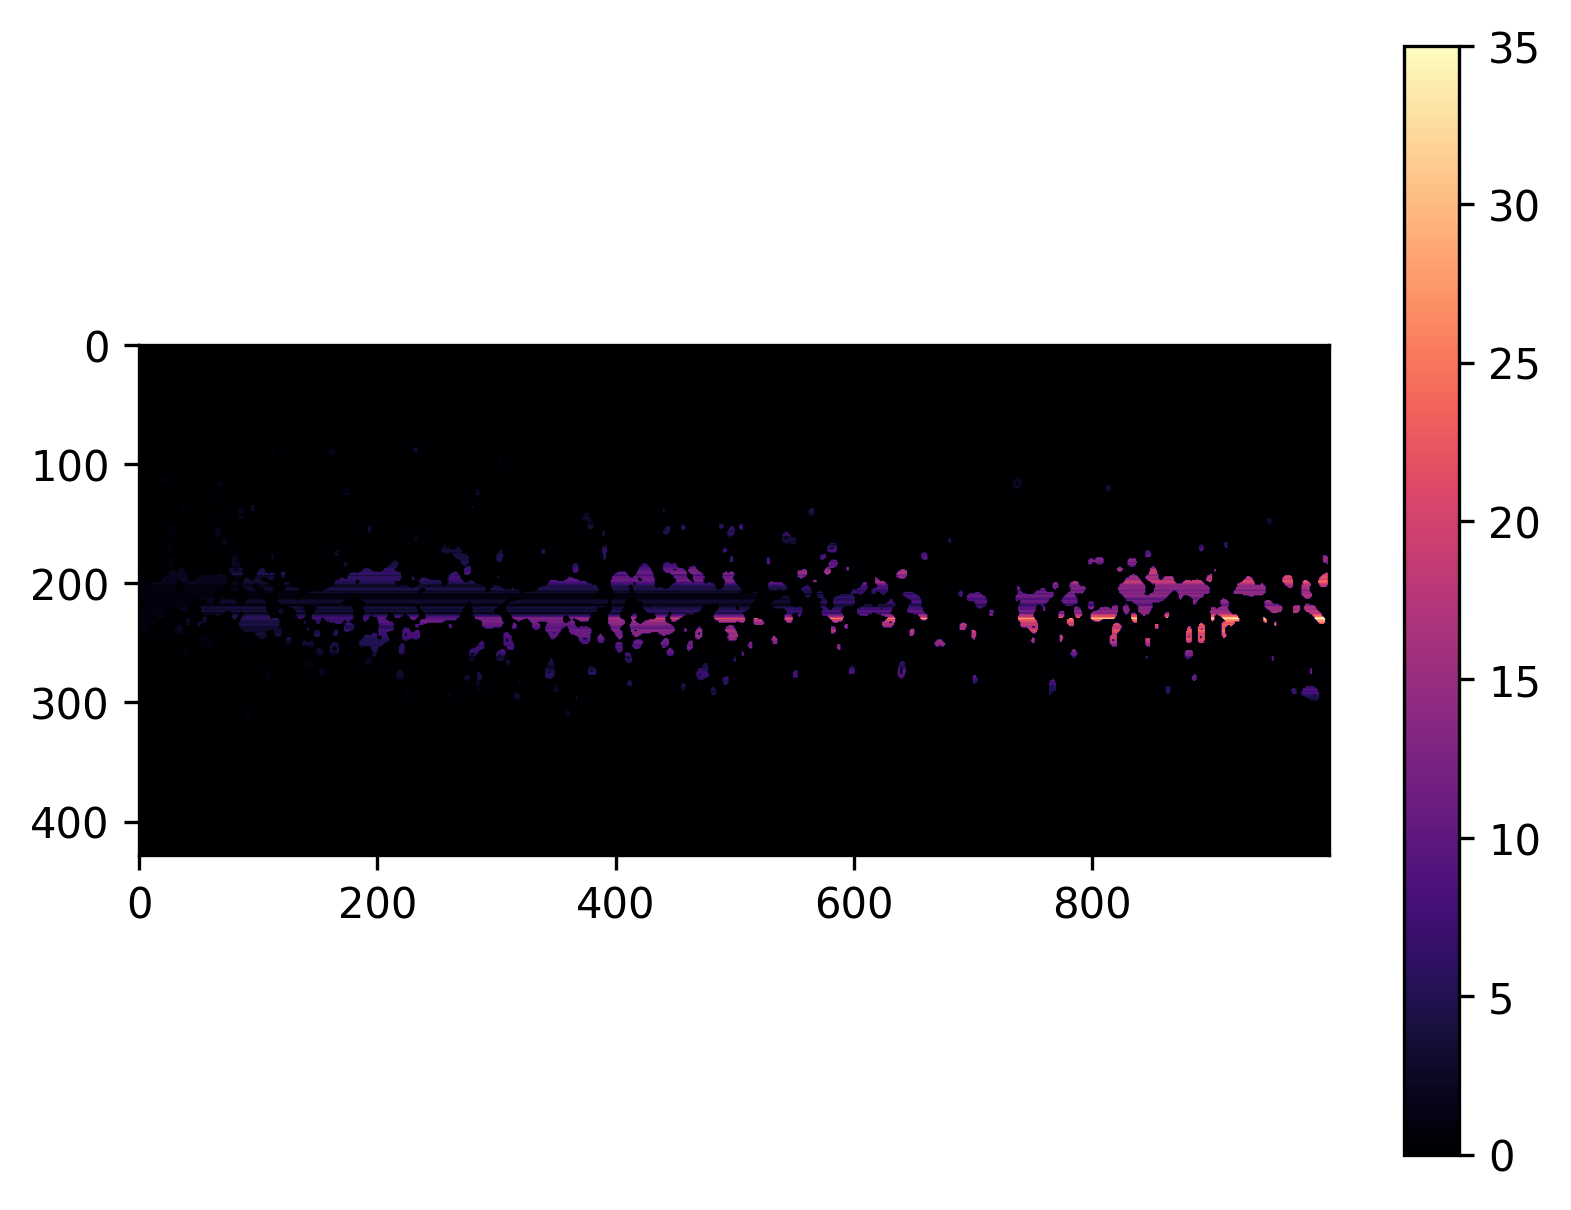

In [34]:
from skimage.measure import label, regionprops

kymos = exp1.labeled_img_array.copy()


plt.imshow(np.swapaxes(kymos,0,1)[0],cmap="magma")
plt.colorbar()
plt.show()

In [31]:
plt.hist(speeds,bins=100)
plt.show()

NameError: name 'speeds' is not defined

Run this cell after the previous or it will be shit. This plot is an overlay of the detected events (and their velocity color coded) over the first time point of the raw timelapse

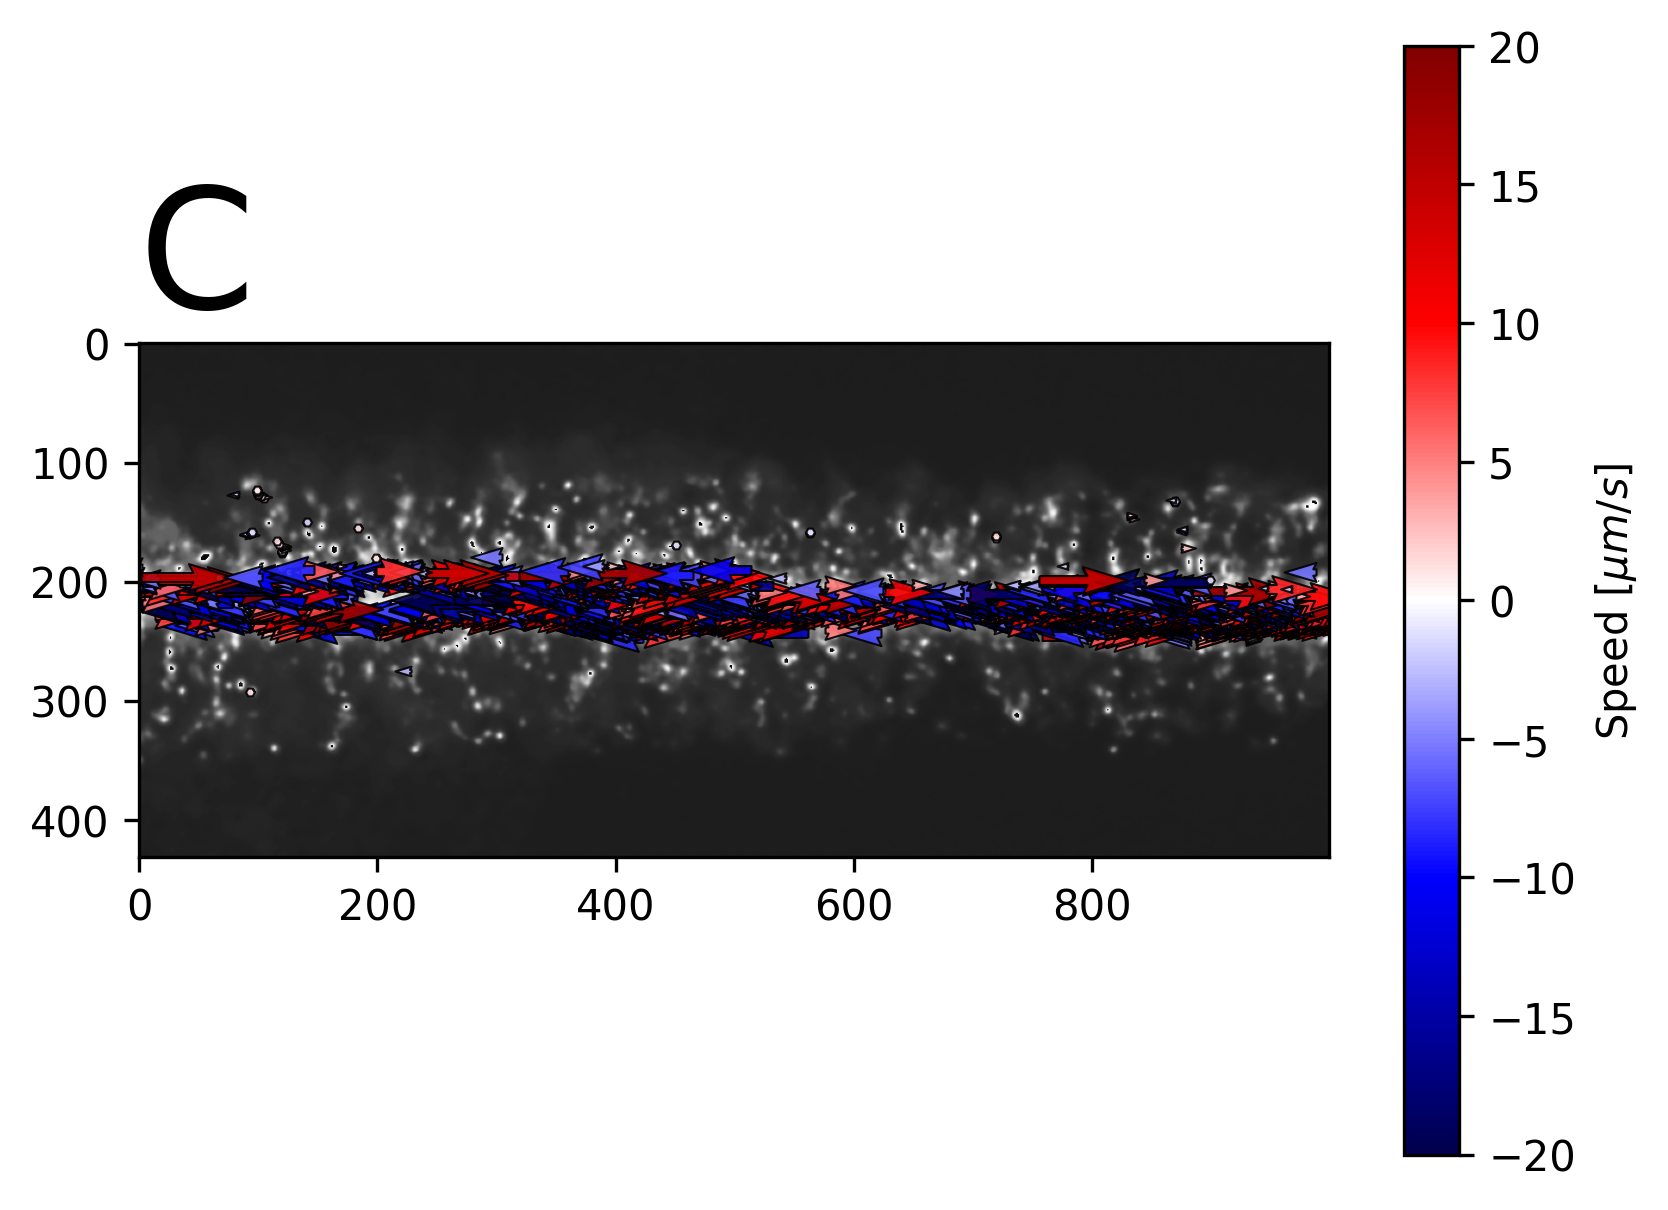

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
plt.rcParams['figure.dpi'] = 300
# Assuming exp1 is an object containing image data
raw_image = exp1.images.copy()
kymos = exp1.labeled_img_array.copy()

# Create a figure and axes
fig, axs = plt.subplots()

# Display the first image from the copied images using axs.imshow()
img = axs.imshow(raw_image[0], cmap="gray")

# Add a colorbar to the plot using the mappable object (img)
#cbar = plt.colorbar(img, ax=axs)

# Create a color map and a normalized scalar mappable for the arrows
cmap = plt.get_cmap('seismic')  # You can choose any colormap you prefer
norm = plt.Normalize(vmin=-20, vmax=20)
sm = plt.cm.ScalarMappable(cmap=cmap,norm = norm)

for id, kymo in enumerate(kymos):
    for region in regionprops(kymo):
        
        if (region.area < 100) and (region.area >= 15) and (region.eccentricity>0.9) and (np.degrees(region.orientation)>-95) and (np.degrees(region.orientation)<95) and (np.round(region.orientation,1)!= 0.0):         
         
            # Calculate speed
            speed = -(np.tan(-region.orientation))*(pixel_size/frame_time) 
            if (speed<20 and speed>-20) and not (speed>-1 and speed<1):
                          
                # Add an arrow to the plot
                arrow_color = cmap(norm(speed))
            
                axs.quiver(region.bbox[1], len(kymos)-id, np.sign(speed), 0, # we need to adjust the y-coordinate
                        angles='xy', 
                        scale_units='xy',
                        scale = abs(1/speed)/5,
                        edgecolor="black",
                        linewidth=.5,
                        color=arrow_color,
                        alpha=0.9
                        )

# Add colorbar
cbar = plt.colorbar(sm, ax=axs)
cbar.set_label(r'Speed [$\mu m / s$]')
plt.title("C",loc="left",size=40)
plt.show()
